In [97]:
import datetime as dt
import pandas as pd
import numpy as np
import quandl
quandl.ApiConfig.api_key = 'TFPsUSNkbZiK8TgJJ_qa'

In [122]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [99]:
start_date = dt.date(2006,11,1)
end_date = dt.date(2015,12,31)

In [100]:
mkt = quandl.get('YAHOO/INDEX_GSPC',start_date=start_date,end_date=end_date)

In [101]:
mkt['val'] = mkt['Adjusted Close']
mkt['volume'] = mkt['Volume']
mkt['r'] = np.log(mkt['Close']/mkt['Open'])
mkt = mkt[['val','volume','r']]

In [102]:
mkt['r'] = (mkt.r-mkt.r.mean())/mkt.r.std()
mkt['tr'] = mkt.r.shift(-1)

In [103]:
vix = quandl.get('CBOE/VIX',start_date=start_date,end_date=end_date)

In [104]:
vix['vix'] = vix['VIX Close']
vix = vix[['vix']]

In [105]:
mkt = mkt.join(vix)

In [106]:
mkt['vals'] = (mkt.val - mkt.val.mean())/mkt.val.std()
mkt['vixs'] = (mkt.vix - mkt.vix.mean())/mkt.vix.std()

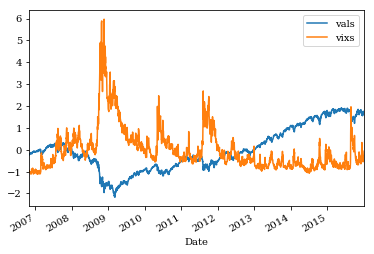

In [107]:
mkt[['vals','vixs']].plot();

In [108]:
mkt['yval'] = mkt.val.shift(1)
mkt['yvix'] = mkt.vix.shift(1)
mkt['lvix'] = np.log(mkt.vix)
mkt['lyvix'] = np.log(mkt.yvix)

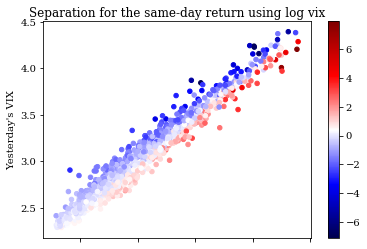

In [109]:
mkt.plot.scatter('lyvix','lvix',c=mkt.r,cmap='seismic');
plt.title('Separation for the same-day return using log vix');
plt.xlabel('Today\'s VIX');
plt.ylabel('Yesterday\'s VIX');

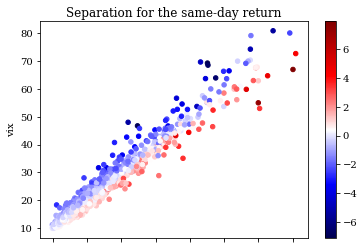

In [123]:
mkt.plot.scatter('yvix','vix',c=mkt.r,cmap='seismic');
plt.title('Separation for the same-day return');

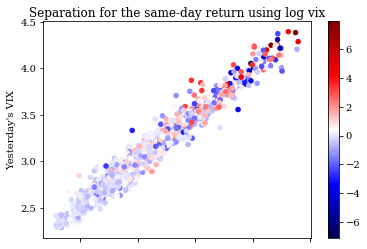

In [110]:
mkt.plot.scatter('lyvix','lvix',c=mkt.tr,cmap='seismic');
plt.title('Separation for the same-day return using log vix');
plt.xlabel('Today\'s VIX');
plt.ylabel('Yesterday\'s VIX');

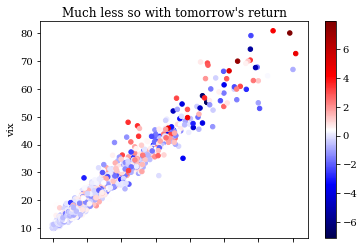

In [112]:
mkt.plot.scatter('yvix','vix',c=mkt.tr,cmap='seismic');
plt.title('Much less so with tomorrow\'s return');

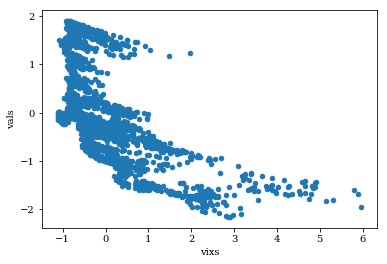

In [113]:
mkt.plot.scatter('vixs','vals');

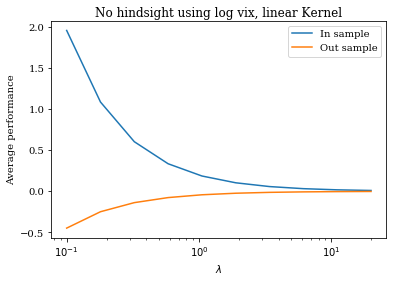

In [292]:
plt.plot(ls,tinps,ls,toutps)
plt.xscale('log')
plt.legend(['In sample','Out sample'])
plt.xlabel('$\lambda$');
plt.ylabel('Average performance')
plt.title('Total hindsight using log vix');
plt.title('No hindsight using log vix, linear Kernel');

## Predicting today's decision, with today's log vix and yesterday's log vix, primal problem

In [314]:
import cvxpy as cvx

In [317]:
rnu = lambda x:x
expu = lambda x: -cvx.exp(-x)

In [315]:
n = len(mkt)-2
X = mkt[['lyvix','lvix']]
X = X.values[1:-1,:]
X = np.column_stack((X,np.ones(n)))
r = mkt.r.values[1:-1]
tr = mkt.tr.values[1:-1]

X,X_test = X[:1800],X[1800:]
r,r_test = r[:1800],r[1800:]
tr,tr_test = tr[:1800],tr[1800:]

In [0]:
# Solve primal problem
def solve(u,l,r):
    _,m = X.shape
    q = cvx.Variable(m)
    obj = cvx.sum_entries(u(cvx.mul_elemwise(r,X*q))) - l*cvx.norm(q)**2
    prob = cvx.Problem(cvx.Maximize(obj))
    prob.solve()
    q = q.value.A1
    return q

In [380]:
q = solve(expu,1,r)

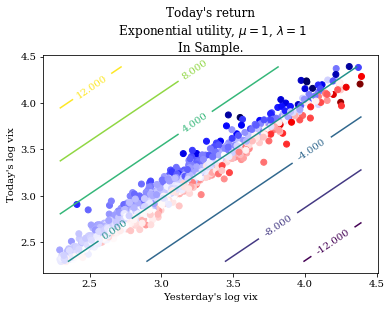

In [368]:
plt.scatter(X[:,0],X[:,1],c=r,cmap='seismic');
delta = 50
xx1 = np.linspace(min(X[:,0]),max(X[:,0]),delta)
xx2 = np.linspace(min(X[:,1]),max(X[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
Z = np.inner(X_s,q).reshape((delta,delta))
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);
plt.xlabel('Yesterday\'s log vix');
plt.ylabel('Today\'s log vix');
plt.title('Today\'s return\n Exponential utility, $\mu = 1$, $\lambda=1$\nIn Sample.');

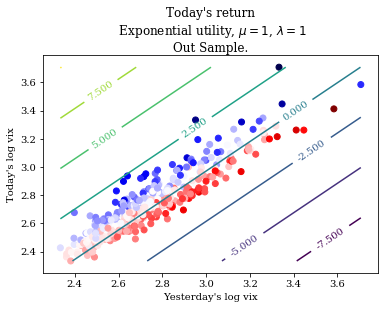

In [371]:
plt.scatter(X_test[:,0],X_test[:,1],c=r_test,cmap='seismic');
delta = 50
xx1 = np.linspace(min(X_test[:,0]),max(X_test[:,0]),delta)
xx2 = np.linspace(min(X_test[:,1]),max(X_test[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
Z = np.inner(X_s,q).reshape((delta,delta))
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);
plt.xlabel('Yesterday\'s log vix');
plt.ylabel('Today\'s log vix');
plt.title('Today\'s return\n Exponential utility, $\mu = 1$, $\lambda=1$\nOut Sample.');

In [396]:
q = solve(rnu,50,r)

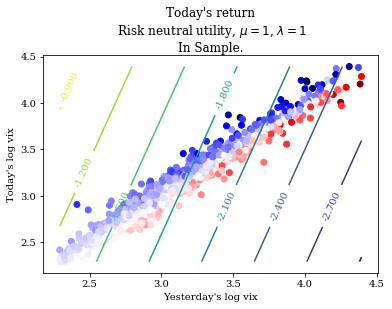

In [393]:
plt.scatter(X[:,0],X[:,1],c=r,cmap='seismic');
delta = 50
xx1 = np.linspace(min(X[:,0]),max(X[:,0]),delta)
xx2 = np.linspace(min(X[:,1]),max(X[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
Z = np.inner(X_s,q).reshape((delta,delta))
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);
plt.xlabel('Yesterday\'s log vix');
plt.ylabel('Today\'s log vix');
plt.title('Today\'s return\n Risk neutral utility, $\mu = 1$, $\lambda=1$\nIn Sample.');

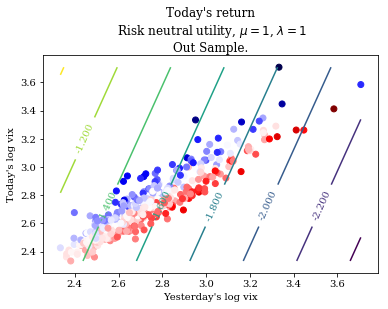

In [395]:
plt.scatter(X_test[:,0],X_test[:,1],c=r_test,cmap='seismic');
delta = 50
xx1 = np.linspace(min(X_test[:,0]),max(X_test[:,0]),delta)
xx2 = np.linspace(min(X_test[:,1]),max(X_test[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
Z = np.inner(X_s,q).reshape((delta,delta))
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);
plt.xlabel('Yesterday\'s log vix');
plt.ylabel('Today\'s log vix');
plt.title('Today\'s return\n Risk neutral utility, $\mu = 1$, $\lambda=1$\nOut Sample.');

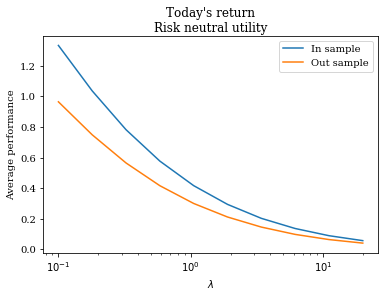

In [398]:
ls = np.logspace(-1,1.3,10)
qs = [solve(expu,l,r) for l in ls]
inps = [np.mean(r*(X@q)) for q in qs]
outps = [np.mean(r_test*(X_test@q)) for q in qs]
plt.plot(ls,inps,ls,outps)
plt.xscale('log')
plt.legend(['In sample','Out sample'])
plt.xlabel('$\lambda$');
plt.ylabel('Average performance')
plt.title('Today\'s return\nRisk neutral utility');

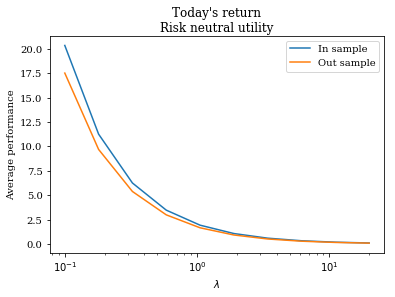

In [397]:
ls = np.logspace(-1,1.3,10)
qs = [solve(rnu,l,r) for l in ls]
inps = [np.mean(r*(X@q)) for q in qs]
outps = [np.mean(r_test*(X_test@q)) for q in qs]
plt.plot(ls,inps,ls,outps)
plt.xscale('log')
plt.legend(['In sample','Out sample'])
plt.xlabel('$\lambda$');
plt.ylabel('Average performance')
plt.title('Today\'s return\nRisk neutral utility');

## Predicting tomorrow's decision, with today's log vix and yesterday's log vix, dual problem, gaussian kernel

In [402]:
from scipy.spatial.distance import pdist,cdist,squareform

In [477]:
sigma = 0.0016681

In [0]:
K = np.exp(-squareform(pdist(X))**2/sigma)
n,_ = K.shape

In [501]:
def solveg(sigma,l,r):
    # Only valid for exponential utility u(r) = -exp(-r)
    K = np.exp(-squareform(pdist(X))**2/sigma)
    n,_ = K.shape
    a = cvx.Variable(n)
    ra = cvx.mul_elemwise(r,a)
    obj = -cvx.sum_entries(cvx.kl_div(a,1)) - l*cvx.quad_form(ra,K)
    prob = cvx.Problem(cvx.Maximize(obj))
    prob.solve(solver=cvx.SCS)
    a = a.value.A1
    return a

In [502]:
a = solveg(sigma,5,tr)

In [481]:
def phi(sigma,X_s):
    phi = np.exp(-cdist(X,X_s)**2/sigma).T
    return phi

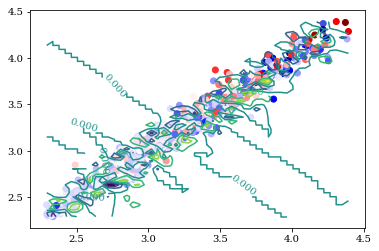

In [482]:
delta = 50
xx1 = np.linspace(min(X[:,0]),max(X[:,0]),delta)
xx2 = np.linspace(min(X[:,1]),max(X[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
# phi = np.exp(-cdist(X,X_s)**2/sigma).T
Z = np.inner(phi(sigma,X_s),a*tr).reshape((delta,delta))
plt.scatter(X[:,0],X[:,1],c=tr,cmap='seismic');
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);

In [495]:
%timeit solveg(sigmas[-1],8,tr)

1 loop, best of 3: 4.3 s per loop


In [491]:
sigmas = np.logspace(-3,-1,10)
alphas = [solveg(sigma,8,tr) for sigma in sigmas]

In [492]:
outps = [np.mean(tr_test*np.inner(phi(sigma,X_test),a*tr)) for sigma,a in zip(sigmas,alphas)]
inps = [np.mean(tr*np.inner(phi(sigma,X),a*tr)) for sigma,a in zip(sigmas,alphas)]

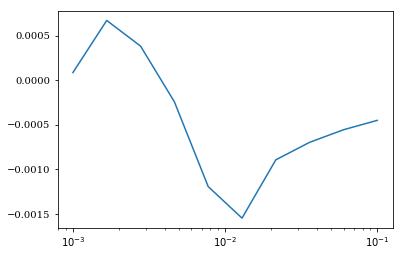

In [493]:
plt.plot(sigmas,outps)
plt.xscale('log')
# plt.axis(ymax=0);

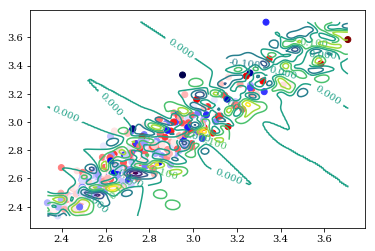

In [490]:
delta = 150
xx1 = np.linspace(min(X_test[:,0]),max(X_test[:,0]),delta)
xx2 = np.linspace(min(X_test[:,1]),max(X_test[:,1]),delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
# phi = np.exp(-cdist(X,X_s)**2/sigma).T
Z = np.inner(phi(sigma,X_s),alphas[1]*tr).reshape((delta,delta))
plt.scatter(X_test[:,0],X_test[:,1],c=tr_test,cmap='seismic');
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont);

In [475]:
sigmas

array([ 0.001     ,  0.0016681 ,  0.00278256,  0.00464159,  0.00774264,
        0.0129155 ,  0.02154435,  0.03593814,  0.05994843,  0.1       ])

In [620]:
a

array([ 0.67227943,  0.72709364,  0.44917895, ...,  0.98220559,
        0.42093542,  0.95491858])

## Predicting tomorrow's decision, with last days log vix measurements, gaussian kernel, with CV

In [637]:
n = len(mkt)
d = 1                          # Number of days to consider

In [638]:
u = lambda x: -np.exp(-x)

In [639]:
cols = ['lyvix'+str(i) for i in range(1,d+1)]
for i,col in enumerate(cols):
    mkt[col] = mkt.lvix.shift(i+1)

In [640]:
sigma = 0.0016

In [641]:
X = mkt[['lvix']+cols].values[d:-1,:]
X = np.column_stack((X,np.ones(n-d-1)))
tr = mkt.tr.values[d:-1]
X,X_test = X[:1800],X[1800:]
tr,tr_test = tr[:1800],tr[1800:]
n,p = X.shape

In [642]:
def problem(sigma):
    K = np.exp(-squareform(pdist(X))**2/sigma)
    a = cvx.Variable(n)
    ra = cvx.mul_elemwise(tr,a)
    l = cvx.Parameter(sign='positive')
    objective = -cvx.sum_entries(cvx.kl_div(a,1)) - l*cvx.quad_form(ra,K)
    prob = cvx.Problem(cvx.Maximize(objective))
    def solve(lamb):
        l.value = lamb
        prob.solve(solver=cvx.SCS)
        anum = a.value.A1
        return anum
    return solve

In [643]:
def utilities(a,sigma,X_test,tr_test):
    phi = np.exp(-cdist(X,X_test)**2/sigma).T
    p = tr_test * np.inner(phi,a*tr)
    return u(p)

In [655]:
def outsample(lambdas,sigmas):
    rez = np.zeros((len(sigmas),len(lambdas)))
    for i,sigma in enumerate(sigmas):
        prob = problem(sigma)
        for j,lamb in enumerate(lambdas):
            a = prob(lamb)
            uts = utilities(a,sigma,X_test,tr_test)
            rez[i,j] = np.mean(uts)
    return rez

In [656]:
t = outsample([5],[1])

In [657]:
t

array([[-1.00083338]])

In [651]:
phi = np.exp(-cdist(X,X_test)**2/sigma).T
cdist(X,X_test)**2/sigma

array([[  22.36905238,   37.83365727,   49.52673691, ...,  157.53060055,
         165.68331596,  177.39014554],
       [  28.46180519,   45.09424787,   57.95312315, ...,  172.27215858,
         179.67957237,  192.98116263],
       [  31.30236835,   50.37028182,   63.56684788, ...,  181.83990676,
         191.31140416,  203.16413567],
       ..., 
       [   5.59910037,    6.56392303,   12.37750882, ...,   79.80878226,
          82.35989638,   93.86861631],
       [   5.65280229,   11.43678288,   18.4456521 , ...,   96.02118866,
         101.74559129,  111.58950634],
       [   4.54205775,   11.45099617,   18.15867518, ...,   95.54806535,
         103.01604058,  111.14805646]])

In [648]:
c

NameError: name 'c' is not defined

In [619]:
a

array([ 0.67227943,  0.72709364,  0.44917895, ...,  0.98220559,
        0.42093542,  0.95491858])

In [603]:
prob = problem(sigma)


In [604]:
a = prob(5)

In [605]:
a

array([ 0.67227943,  0.72709364,  0.44917895, ...,  0.98220559,
        0.42093542,  0.95491858])

In [607]:
phi = np.exp(-cdist(X,X_test)**2/sigma).T

In [608]:
phi

array([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          3.21054177e-183,   2.04056924e-132,   1.06983139e-074],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          9.95819672e-267,   1.84861608e-187,   1.07665674e-134],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          1.11596174e-313,   2.61030405e-280,   5.98319031e-195],
       ..., 
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000]])